# Presentazione progetto

<b>Materia</b>: Ingegneria dei sistemi distribuiti <br>
<b>Matricola</b>: 1000055729 <br>
<b>Studente</b>: Giuseppe Condorelli <br>
<b>Supervisore</b>: Prof. Emiliano Tramontana <br>

## Descrizione

L'obiettivo del progetto è quello di utilizzare le api disponibili di stackoverflow al fine di raccogliere sufficienti dati per il build di un dataset di classificazione supervisionata.

Nello specifico il dataset dovrà contenere domande e commenti (inclusi i codici) presenti su stackoverflow includendone il topic di appartenza (ovvero la classe).
Dopodichè il dataset verrà usato per la creazione e training di un modello di classificazione che dovrà essere in grado, dato del codice java, di classificarne i topic di appartenenza.

# Libraries

In [29]:
import requests
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
import ast

import matplotlib.pyplot as plt
import seaborn as sns

import re

# Global variables declaration

In [2]:
api_key = '2zg)Cc)MkDwvS2LKyRfbHg((&'
main_tag = 'java'
tags_number = 60

# Functions

In [30]:
def get_response(url):
    print(url)
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print(f"Failed to fetch data from API. Status code: {response.status_code}")
        exit()

def fetch_data(tag, api_key, filter = 'withbody'):
    url = f'https://api.stackexchange.com/2.3/questions?order=desc&sort=activity&tagged={tag}&site=stackoverflow&key={api_key}&filter={filter}'
    
    print(url)

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        questions = data['items']
        return questions

    else:
        print(f"Failed to fetch data from API. Status code: {response.status_code}")
        exit()


def fetch_questions(tags, api_key, show = True):
    data = []
    for tag in tags:
        if show:
            print(f"Fetching questions for tags: {main_tag} and {tag}")
        questions = fetch_data(f'{main_tag};tag', api_key)

        for question in questions:
                title = get_question_title(question, show)
                body = get_question_body(question, show)
                tags = get_question_tags(question, show)
                
                answers = fetch_answers_for_question(api_key, question['question_id'])
                
                question_data = {'title': title,
                                 'body': body,
                                 'answers': answers,
                                 'tags': tags}
                data.append(question_data)
                
    dataframe = pd.DataFrame(data)
    
    return dataframe

            
def get_question_title(question, show = True):
    title = question['title']
    if show:
        print(f"Title: {title}")
    return title

def get_question_body(question, show = True):
    body = question['body']
    if show:
        print(f"Question:\n{body}")
    return body

def get_question_tags(question, show = True):
    tags = question['tags']
    if show:
        print(f"Tags: {tags}")
    return tags
        
def fetch_answers_for_question(api_key, question_id):
    url = f'https://api.stackexchange.com/2.3/questions/{question_id}/answers?order=desc&sort=activity&site=stackoverflow&key={api_key}&filter=!9YdnSMKKT'  # Updated filter

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        answers = data['items']

        for answer in answers:
            answer_body = answer['body']
            # print(f"Answer:\n{answer_body}\n")
            return answer_body

    else:
        print(f"Failed to fetch answers for question {question_id}. Status code: {response.status_code}")
        
        
def get_all_related_tags(tag):
    page = 1
    all_tags = []
    has_more = True

    while has_more:
        url = f"https://api.stackexchange.com/2.3/tags/{tag}/related?site=stackoverflow&page={page}&pagesize=100"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            all_tags.extend(data['items'])
            has_more = data.get('has_more', False)
            page += 1
        else:
            print(f"Errore nella chiamata API: {response.status_code}")
            has_more = False

    return all_tags


def read_list(path):
    
    list = []

    with open(path, 'r') as file:
        list = [line.strip() for line in file]
    
    return list

def remove_tags(text, tags):
    for tag in tags:
        text = re.sub(re.escape(tag), "", text, flags=re.IGNORECASE)
    return text

# Web scraping

## Most common tags used with java

In [9]:
related_tags = get_all_related_tags('java')

for tag in related_tags:
    print(f"Tag: {tag['name']}, Count: {tag['count']}")

Tag: java, Count: 1920867
Tag: android, Count: 282333
Tag: spring, Count: 130602
Tag: swing, Count: 79866
Tag: spring-boot, Count: 77646
Tag: eclipse, Count: 59576
Tag: hibernate, Count: 59303
Tag: arrays, Count: 52444
Tag: maven, Count: 48680
Tag: multithreading, Count: 39521
Tag: json, Count: 39388
Tag: xml, Count: 36625
Tag: selenium-webdriver, Count: 35683
Tag: string, Count: 32712
Tag: spring-mvc, Count: 32532
Tag: jpa, Count: 31791
Tag: mysql, Count: 30688
Tag: jsp, Count: 27468
Tag: arraylist, Count: 26474
Tag: javafx, Count: 24956
Tag: tomcat, Count: 23725
Tag: regex, Count: 23527
Tag: android-studio, Count: 23217
Tag: servlets, Count: 23170
Tag: jdbc, Count: 22664
Tag: javascript, Count: 21257
Tag: rest, Count: 20439
Tag: junit, Count: 19048
Tag: sql, Count: 18648
Tag: generics, Count: 18092
Tag: java-8, Count: 17842
Tag: intellij-idea, Count: 17605
Tag: jakarta-ee, Count: 16696
Tag: exception, Count: 15507
Tag: html, Count: 15292
Tag: algorithm, Count: 15275
Tag: gradle, Coun

In [11]:
most_common_tags = []

# Popola la lista con i primi 40 tag
for tag in related_tags[0:tags_number]:
    most_common_tags.append(tag['name'])

print(most_common_tags)

['java', 'android', 'spring', 'swing', 'spring-boot', 'eclipse', 'hibernate', 'arrays', 'maven', 'multithreading', 'json', 'xml', 'selenium-webdriver', 'string', 'spring-mvc', 'jpa', 'mysql', 'jsp', 'arraylist', 'javafx', 'tomcat', 'regex', 'android-studio', 'servlets', 'jdbc', 'javascript', 'rest', 'junit', 'sql', 'generics', 'java-8', 'intellij-idea', 'jakarta-ee', 'exception', 'html', 'algorithm', 'gradle', 'netbeans', 'jar', 'sockets', 'web-services', 'database', 'file', 'user-interface', 'kotlin', 'jackson', 'class', 'spring-security', 'spring-data-jpa', 'methods']


### Removing java tag

In [13]:
most_common_tags.remove('java')

print(most_common_tags)

['android', 'spring', 'swing', 'spring-boot', 'eclipse', 'hibernate', 'arrays', 'maven', 'multithreading', 'json', 'xml', 'selenium-webdriver', 'string', 'spring-mvc', 'jpa', 'mysql', 'jsp', 'arraylist', 'javafx', 'tomcat', 'regex', 'android-studio', 'servlets', 'jdbc', 'javascript', 'rest', 'junit', 'sql', 'generics', 'java-8', 'intellij-idea', 'jakarta-ee', 'exception', 'html', 'algorithm', 'gradle', 'netbeans', 'jar', 'sockets', 'web-services', 'database', 'file', 'user-interface', 'kotlin', 'jackson', 'class', 'spring-security', 'spring-data-jpa', 'methods']


In [14]:
# Salva la lista in un file di testo
with open('most_common_tags.txt', 'w') as file:
    for tag in most_common_tags:
        file.write(tag + '\n')

### Fetching questions

In [16]:
result = fetch_questions(most_common_tags, api_key, show = True)

Fetching questions for tags: java and android
https://api.stackexchange.com/2.3/questions?order=desc&sort=activity&tagged=java;tag&site=stackoverflow&key=2zg)Cc)MkDwvS2LKyRfbHg((&&filter=withbody
Title: &quot;Multiple root tags&quot; and &quot;Top level element is not completed&quot; error in AndroidManifest.xml. What am i doing wrong?
Question:
<pre><code>&lt;?xml version=&quot;1.0&quot; encoding=&quot;utf-8&quot;?&gt;
&lt;manifest xmlns:android=&quot;http://schemas.android.com/apk/res/android&quot;
    xmlns:tools=&quot;http://schemas.android.com/tools&quot;
    package=&quot;com.example.transkript&quot;&gt;

    &lt;uses-permission android:name=&quot;android.permission.RECORD_AUDIO&quot; /&gt;
    &lt;uses-permission android:name=&quot;android.permission.INTERNET&quot; /&gt;
    &lt;uses-permission android:name=&quot;android.permission.WRITE_EXTERNAL_STORAGE&quot; /&gt;

    &lt;application
        android:allowBackup=&quot;true&quot;
        android:icon=&quot;@mipmap/ic_launcher&q

In [17]:
display(result)

,title,body,answers,tags
0,&quot;Multiple root tags&quot; and &quot;Top l...,<pre><code>&lt;?xml version=&quot;1.0&quot; en...,<p>The XML declaration (not a &quot;tag&quot;)...,"[java, android, xml, tags]"
1,Read .m4a Tags on Android,<p>I recently started building an audio tag ed...,<p>Jaudiotagger processes mp4 and m4a <strong>...,"[java, android, audio, tags, m4a]"
2,How to fix FileUploadBase$SizeLimitExceededExc...,<p>How to handle custom inteceptors execptions...,<p>Set this constant to increase a request lim...,"[java, file-upload, struts2, tags]"
3,Java Web Application - Get Between String,<p>I'm making a Java web application that find...,<p>To get the website source code via scraping...,"[java, tags]"
4,&lt;c:out/&gt; unknown tag,<p>Why I get error tip message in eclipse on l...,<p>If ur using maven dependency see wether the...,"[java, eclipse, jsp, tags, jstl]"
...,...,...,...,...
1465,Getting Google Chrome out of memory issue due ...,<p>Getting Google Chrome out of memory issue d...,None,"[java, jsp, browser, tags, struts-1]"
1466,JAXB don&#39;t marshal attribute,<p>I have some class generated by jaxb mave pl...,None,"[java, xml, attributes, tags, jaxb]"
1467,Round method for &lt;fmt:formatNumber maxFract...,<p>How does rounding works with this tag? Only...,None,"[java, jsp, tags, rounding]"
1468,Purpose of tag library?,<p>What is the purpose of having tag library? ...,<p>While you can do basic things like accessin...,"[java, jsp, struts, tags, jsp-tags]"


In [18]:
result.to_csv('dataset.csv', index=False)

## Dataset cleaning
- Keeping tags only present in 'most_common_tags'

In [31]:
dataset = pd.read_csv('dataset.csv')

display(dataset)

most_common_tags = read_list("most_common_tags.txt")

print(f"Top {len(most_common_tags)} tags: ", most_common_tags)

,title,body,answers,tags
0,&quot;Multiple root tags&quot; and &quot;Top l...,<pre><code>&lt;?xml version=&quot;1.0&quot; en...,<p>The XML declaration (not a &quot;tag&quot;)...,"['java', 'android', 'xml', 'tags']"
1,Read .m4a Tags on Android,<p>I recently started building an audio tag ed...,<p>Jaudiotagger processes mp4 and m4a <strong>...,"['java', 'android', 'audio', 'tags', 'm4a']"
2,How to fix FileUploadBase$SizeLimitExceededExc...,<p>How to handle custom inteceptors execptions...,<p>Set this constant to increase a request lim...,"['java', 'file-upload', 'struts2', 'tags']"
3,Java Web Application - Get Between String,<p>I'm making a Java web application that find...,<p>To get the website source code via scraping...,"['java', 'tags']"
4,&lt;c:out/&gt; unknown tag,<p>Why I get error tip message in eclipse on l...,<p>If ur using maven dependency see wether the...,"['java', 'eclipse', 'jsp', 'tags', 'jstl']"
...,...,...,...,...
1465,Getting Google Chrome out of memory issue due ...,<p>Getting Google Chrome out of memory issue d...,NaN,"['java', 'jsp', 'browser', 'tags', 'struts-1']"
1466,JAXB don&#39;t marshal attribute,<p>I have some class generated by jaxb mave pl...,NaN,"['java', 'xml', 'attributes', 'tags', 'jaxb']"
1467,Round method for &lt;fmt:formatNumber maxFract...,<p>How does rounding works with this tag? Only...,NaN,"['java', 'jsp', 'tags', 'rounding']"
1468,Purpose of tag library?,<p>What is the purpose of having tag library? ...,<p>While you can do basic things like accessin...,"['java', 'jsp', 'struts', 'tags', 'jsp-tags']"


Top 49 tags:  ['android', 'spring', 'swing', 'spring-boot', 'eclipse', 'hibernate', 'arrays', 'maven', 'multithreading', 'json', 'xml', 'selenium-webdriver', 'string', 'spring-mvc', 'jpa', 'mysql', 'jsp', 'arraylist', 'javafx', 'tomcat', 'regex', 'android-studio', 'servlets', 'jdbc', 'javascript', 'rest', 'junit', 'sql', 'generics', 'java-8', 'intellij-idea', 'jakarta-ee', 'exception', 'html', 'algorithm', 'gradle', 'netbeans', 'jar', 'sockets', 'web-services', 'database', 'file', 'user-interface', 'kotlin', 'jackson', 'class', 'spring-security', 'spring-data-jpa', 'methods']


### Removing tags not in most_common_tags

In [32]:
tags = dataset['tags']

most_common_tags = set(most_common_tags)

tmp = []

for tag in tags:
    tag = set(eval(tag))
    tag = list(most_common_tags.intersection(tag))
    if(len(tag) > 0):
        tmp.append(tag)
    else:
        tmp.append(None)

dataset['tags'] = tmp

display(dataset)    

,title,body,answers,tags
0,&quot;Multiple root tags&quot; and &quot;Top l...,<pre><code>&lt;?xml version=&quot;1.0&quot; en...,<p>The XML declaration (not a &quot;tag&quot;)...,"[android, xml]"
1,Read .m4a Tags on Android,<p>I recently started building an audio tag ed...,<p>Jaudiotagger processes mp4 and m4a <strong>...,[android]
2,How to fix FileUploadBase$SizeLimitExceededExc...,<p>How to handle custom inteceptors execptions...,<p>Set this constant to increase a request lim...,None
3,Java Web Application - Get Between String,<p>I'm making a Java web application that find...,<p>To get the website source code via scraping...,None
4,&lt;c:out/&gt; unknown tag,<p>Why I get error tip message in eclipse on l...,<p>If ur using maven dependency see wether the...,"[jsp, eclipse]"
...,...,...,...,...
1465,Getting Google Chrome out of memory issue due ...,<p>Getting Google Chrome out of memory issue d...,NaN,[jsp]
1466,JAXB don&#39;t marshal attribute,<p>I have some class generated by jaxb mave pl...,NaN,[xml]
1467,Round method for &lt;fmt:formatNumber maxFract...,<p>How does rounding works with this tag? Only...,NaN,[jsp]
1468,Purpose of tag library?,<p>What is the purpose of having tag library? ...,<p>While you can do basic things like accessin...,[jsp]


In [33]:
dataset = dataset[dataset['tags'].map(lambda x: x != None)]

display(dataset)

,title,body,answers,tags
0,&quot;Multiple root tags&quot; and &quot;Top l...,<pre><code>&lt;?xml version=&quot;1.0&quot; en...,<p>The XML declaration (not a &quot;tag&quot;)...,"[android, xml]"
1,Read .m4a Tags on Android,<p>I recently started building an audio tag ed...,<p>Jaudiotagger processes mp4 and m4a <strong>...,[android]
4,&lt;c:out/&gt; unknown tag,<p>Why I get error tip message in eclipse on l...,<p>If ur using maven dependency see wether the...,"[jsp, eclipse]"
7,Create GCP tags and attach it to VM using goog...,<p>Need help with google client lib for creati...,NaN,[spring-boot]
8,Java - execution order between Junit tags and ...,<p>is there any conjunction between Junit tags...,NaN,[junit]
...,...,...,...,...
1465,Getting Google Chrome out of memory issue due ...,<p>Getting Google Chrome out of memory issue d...,NaN,[jsp]
1466,JAXB don&#39;t marshal attribute,<p>I have some class generated by jaxb mave pl...,NaN,[xml]
1467,Round method for &lt;fmt:formatNumber maxFract...,<p>How does rounding works with this tag? Only...,NaN,[jsp]
1468,Purpose of tag library?,<p>What is the purpose of having tag library? ...,<p>While you can do basic things like accessin...,[jsp]


### Filling na with empty string

In [34]:
dataset = dataset.dropna(axis=0, subset=["tags"])
dataset['answers'] = dataset['answers'].fillna(" ")

display(dataset)

,title,body,answers,tags
0,&quot;Multiple root tags&quot; and &quot;Top l...,<pre><code>&lt;?xml version=&quot;1.0&quot; en...,<p>The XML declaration (not a &quot;tag&quot;)...,"[android, xml]"
1,Read .m4a Tags on Android,<p>I recently started building an audio tag ed...,<p>Jaudiotagger processes mp4 and m4a <strong>...,[android]
4,&lt;c:out/&gt; unknown tag,<p>Why I get error tip message in eclipse on l...,<p>If ur using maven dependency see wether the...,"[jsp, eclipse]"
7,Create GCP tags and attach it to VM using goog...,<p>Need help with google client lib for creati...,,[spring-boot]
8,Java - execution order between Junit tags and ...,<p>is there any conjunction between Junit tags...,,[junit]
...,...,...,...,...
1465,Getting Google Chrome out of memory issue due ...,<p>Getting Google Chrome out of memory issue d...,,[jsp]
1466,JAXB don&#39;t marshal attribute,<p>I have some class generated by jaxb mave pl...,,[xml]
1467,Round method for &lt;fmt:formatNumber maxFract...,<p>How does rounding works with this tag? Only...,,[jsp]
1468,Purpose of tag library?,<p>What is the purpose of having tag library? ...,<p>While you can do basic things like accessin...,[jsp]


### Removing tags from features columns to reduce bias

In [35]:
# Applicare la funzione di rimozione dei tag a ciascuna colonna di interesse
dataset['title'] = dataset['title'].apply(lambda x: remove_tags(x, most_common_tags))
dataset['body'] = dataset['body'].apply(lambda x: remove_tags(x, most_common_tags))
dataset['answers'] = dataset['answers'].apply(lambda x: remove_tags(x, most_common_tags))

display(dataset)

,title,body,answers,tags
0,&quot;Multiple root tags&quot; and &quot;Top l...,<pre><code>&lt;? version=&quot;1.0&quot; encod...,"<p>The declaration (not a &quot;tag&quot;),</...","[android, xml]"
1,Read .m4a Tags on,<p>I recently started building an audio tag ed...,<p>Jaudiotagger processes mp4 and m4a <strong>...,[android]
4,&lt;c:out/&gt; unknown tag,<p>Why I get error tip message in on left whe...,<p>If ur using dependency see wether the jstl...,"[jsp, eclipse]"
7,Create GCP tags and attach it to VM using goog...,<p>Need help with google client lib for creati...,,[spring-boot]
8,Java - execution order between tags and Cucum...,<p>is there any conjunction between tags and ...,,[junit]
...,...,...,...,...
1465,Getting Google Chrome out of memory issue due ...,<p>Getting Google Chrome out of memory issue d...,,[jsp]
1466,JAXB don&#39;t marshal attribute,<p>I have some generated by jaxb mave plugin ...,,[xml]
1467,Round method for &lt;fmt:formatNumber maxFract...,<p>How does rounding works with this tag? Only...,,[jsp]
1468,Purpose of tag library?,<p>What is the purpose of having tag library? ...,<p>While you can do basic things like accessin...,[jsp]


### Storing dataset

In [36]:
dataset.to_csv('final_dataset.csv', index=False)

## Data exploration

                                               title  \
0  &quot;Multiple root tags&quot; and &quot;Top l...   
1                                 Read .m4a Tags on    
2                         &lt;c:out/&gt; unknown tag   
3  Create GCP tags and attach it to VM using goog...   
4  Java - execution order between  tags and Cucum...   

                                                body  \
0  <pre><code>&lt;? version=&quot;1.0&quot; encod...   
1  <p>I recently started building an audio tag ed...   
2  <p>Why I get error tip message in  on left whe...   
3  <p>Need help with google client lib for creati...   
4  <p>is there any conjunction between  tags and ...   

                                             answers                tags  
0  <p>The  declaration (not a &quot;tag&quot;),</...  ['android', 'xml']  
1  <p>Jaudiotagger processes mp4 and m4a <strong>...         ['android']  
2  <p>If ur using  dependency see wether the jstl...  ['jsp', 'eclipse']  
3                         

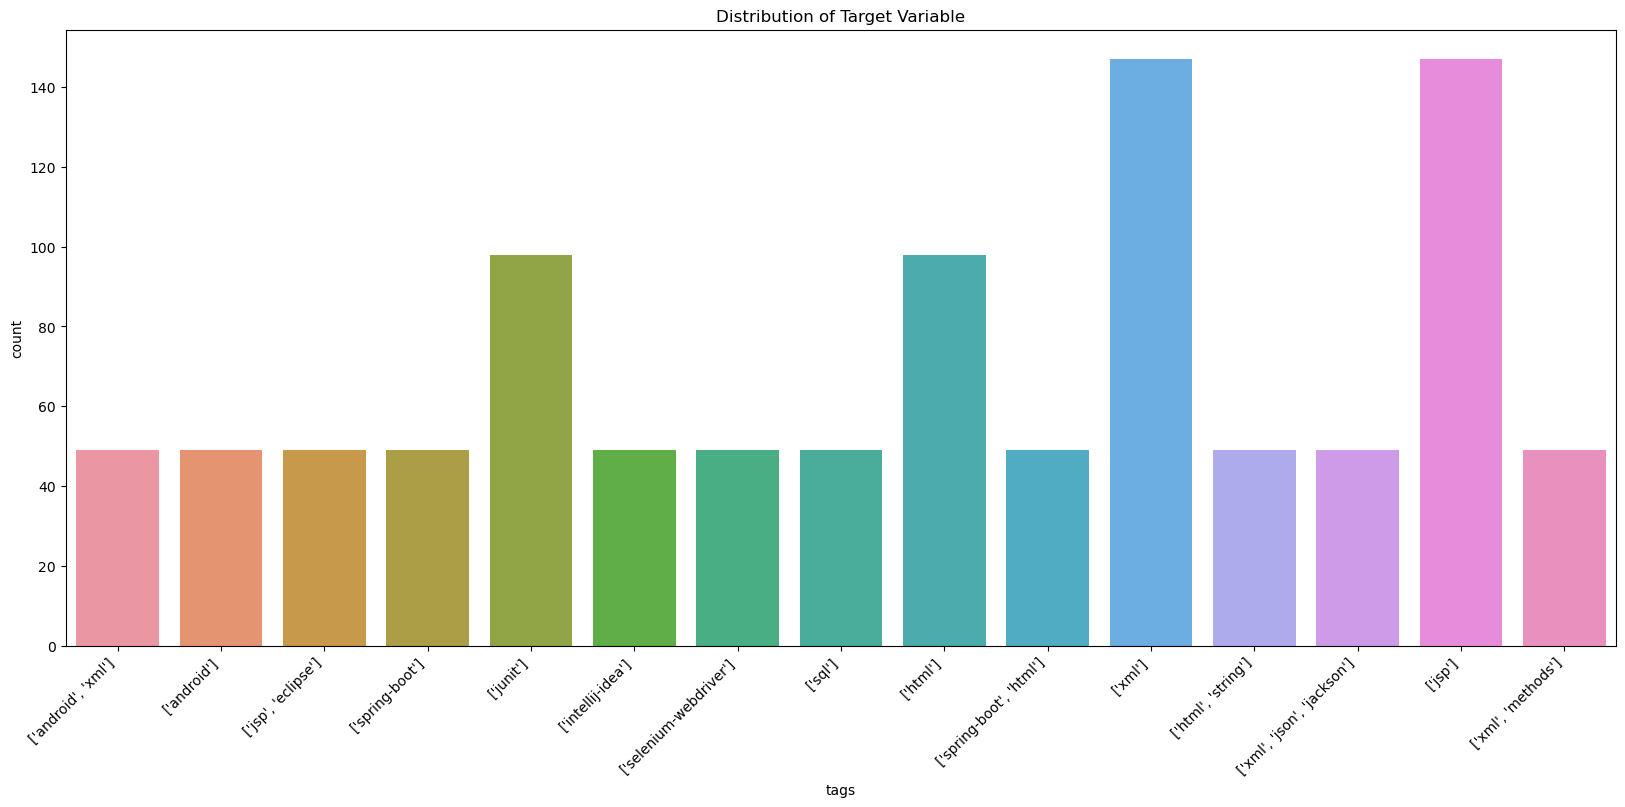

In [37]:
df = pd.read_csv('final_dataset.csv')

print(df.head())

print(df.describe())

print(df.nunique())

plt.figure(figsize=(20,8))
ax = sns.countplot(x='tags', data=df)
plt.title('Distribution of Target Variable')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()


## Machine learning model multi-classifier

### Importing dataset

In [38]:
dataset = pd.read_csv('final_dataset.csv')
display(dataset)

most_common_tags = read_list("most_common_tags.txt")

,title,body,answers,tags
0,&quot;Multiple root tags&quot; and &quot;Top l...,<pre><code>&lt;? version=&quot;1.0&quot; encod...,"<p>The declaration (not a &quot;tag&quot;),</...","['android', 'xml']"
1,Read .m4a Tags on,<p>I recently started building an audio tag ed...,<p>Jaudiotagger processes mp4 and m4a <strong>...,['android']
2,&lt;c:out/&gt; unknown tag,<p>Why I get error tip message in on left whe...,<p>If ur using dependency see wether the jstl...,"['jsp', 'eclipse']"
3,Create GCP tags and attach it to VM using goog...,<p>Need help with google client lib for creati...,,['spring-boot']
4,Java - execution order between tags and Cucum...,<p>is there any conjunction between tags and ...,,['junit']
...,...,...,...,...
1024,Getting Google Chrome out of memory issue due ...,<p>Getting Google Chrome out of memory issue d...,,['jsp']
1025,JAXB don&#39;t marshal attribute,<p>I have some generated by jaxb mave plugin ...,,['xml']
1026,Round method for &lt;fmt:formatNumber maxFract...,<p>How does rounding works with this tag? Only...,,['jsp']
1027,Purpose of tag library?,<p>What is the purpose of having tag library? ...,<p>While you can do basic things like accessin...,['jsp']


In [39]:
# Unisci le colonne di testo in un'unica colonna
dataset['Full_text'] = dataset['title'] + " " + dataset['body'] + " " + dataset['answers']

# Estrai i dati
X = dataset['Full_text']
y =  [ast.literal_eval(value) for value in dataset['tags']]

display(dataset)

,title,body,answers,tags,Full_text
0,&quot;Multiple root tags&quot; and &quot;Top l...,<pre><code>&lt;? version=&quot;1.0&quot; encod...,"<p>The declaration (not a &quot;tag&quot;),</...","['android', 'xml']",&quot;Multiple root tags&quot; and &quot;Top l...
1,Read .m4a Tags on,<p>I recently started building an audio tag ed...,<p>Jaudiotagger processes mp4 and m4a <strong>...,['android'],Read .m4a Tags on <p>I recently started build...
2,&lt;c:out/&gt; unknown tag,<p>Why I get error tip message in on left whe...,<p>If ur using dependency see wether the jstl...,"['jsp', 'eclipse']",&lt;c:out/&gt; unknown tag <p>Why I get error ...
3,Create GCP tags and attach it to VM using goog...,<p>Need help with google client lib for creati...,,['spring-boot'],Create GCP tags and attach it to VM using goog...
4,Java - execution order between tags and Cucum...,<p>is there any conjunction between tags and ...,,['junit'],Java - execution order between tags and Cucum...
...,...,...,...,...,...
1024,Getting Google Chrome out of memory issue due ...,<p>Getting Google Chrome out of memory issue d...,,['jsp'],Getting Google Chrome out of memory issue due ...
1025,JAXB don&#39;t marshal attribute,<p>I have some generated by jaxb mave plugin ...,,['xml'],JAXB don&#39;t marshal attribute <p>I have som...
1026,Round method for &lt;fmt:formatNumber maxFract...,<p>How does rounding works with this tag? Only...,,['jsp'],Round method for &lt;fmt:formatNumber maxFract...
1027,Purpose of tag library?,<p>What is the purpose of having tag library? ...,<p>While you can do basic things like accessin...,['jsp'],Purpose of tag library? <p>What is the purpose...


### Model training

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

mlb = MultiLabelBinarizer()
mlb = mlb.fit([most_common_tags])

y_train_bin = mlb.transform(y_train)
y_test_bin = mlb.transform(y_test)

classifier = MultiOutputClassifier(KNeighborsClassifier())
classifier.fit(X_train_tfidf, y_train_bin)

MultiOutputClassifier(estimator=KNeighborsClassifier())

### Classification report

In [45]:
y_pred = classifier.predict(X_test_tfidf)

# Filtra le classi con supporto maggiore di 0
class_counts = y_test_bin.sum(axis=0)
non_zero_classes = [label for label, support in zip(most_common_tags, class_counts) if support > 0]

non_zero_labels = [i for i in range(len(most_common_tags)) if class_counts[i] > 0]

print(classification_report(y_test_bin, y_pred, target_names=non_zero_classes, labels=non_zero_labels))

                precision    recall  f1-score   support

        spring       1.00      1.00      1.00        18
         maven       1.00      1.00      1.00        15
    spring-mvc       1.00      1.00      1.00        44
           jpa       1.00      1.00      1.00         8
         mysql       1.00      1.00      1.00        10
          jdbc       1.00      1.00      1.00        10
    javascript       1.00      1.00      1.00        42
          rest       1.00      1.00      1.00        20
      generics       1.00      1.00      1.00         6
     algorithm       1.00      1.00      1.00        10
       sockets       1.00      1.00      1.00        23
user-interface       1.00      1.00      1.00         9
        kotlin       1.00      1.00      1.00         8
       methods       1.00      1.00      1.00        55

     micro avg       1.00      1.00      1.00       278
     macro avg       1.00      1.00      1.00       278
  weighted avg       1.00      1.00      1.00 

# Demo

In [42]:
xml_maven_code = """<?xml version="1.0" encoding="UTF-8"?>
<project xmlns="http://maven.apache.org/POM/4.0.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
    xsi:schemaLocation="http://maven.apache.org/POM/4.0.0 https://maven.apache.org/xsd/maven-4.0.0.xsd">
    <modelVersion>4.0.0</modelVersion>

    <groupId>org.springframework</groupId>
    <artifactId>gs-maven</artifactId>
    <packaging>jar</packaging>
    <version>0.1.0</version>

    <properties>
        <maven.compiler.source>1.8</maven.compiler.source>
        <maven.compiler.target>1.8</maven.compiler.target>
    </properties>

    <build>
        <plugins>
            <plugin>
                <groupId>org.apache.maven.plugins</groupId>
                <artifactId>maven-shade-plugin</artifactId>
                <version>3.2.4</version>
                <executions>
                    <execution>
                        <phase>package</phase>
                        <goals>
                            <goal>shade</goal>
                        </goals>
                        <configuration>
                            <transformers>
                                <transformer
                                    implementation="org.apache.maven.plugins.shade.resource.ManifestResourceTransformer">
                                    <mainClass>hello.HelloWorld</mainClass>
                                </transformer>
                            </transformers>
                        </configuration>
                    </execution>
                </executions>
            </plugin>
        </plugins>
    </build>
</project>
"""

In [43]:
mlb.inverse_transform(classifier.predict(vectorizer.transform([xml_maven_code])))

[('junit',)]